# Colab

- 將 baseline 的下游從 svm 轉換為 nn。
- 訓練練資料的正負資料集不平衡。
- cross entropy + weight
- 圖片被裁切成數個小bbox

In [ ]:
cd /content/drive/MyDrive/Projects/AI_CUP-Mango

/content/drive/MyDrive/Projects/AI_CUP-Mango


In [ ]:
pwd

'/content/drive/MyDrive/Projects/AI_CUP-Mango'

# Preparing data

In [ ]:
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pickle 
import matplotlib.pylab as plt # plot module

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible.')
  print('Working on:', torch.cuda.get_device_name())
else:
  device = torch.device('cpu')
  print('GPU is not avalible.')
  print('Working on CPU')

GPU is avalible.
Working on: Tesla T4


In [ ]:
with open('/content/drive/MyDrive/Projects/AI_CUP-Mango/processed_data/train_feature.pkl', 'rb') as f:
    train_feature = pickle.load(f)

with open('/content/drive/MyDrive/Projects/AI_CUP-Mango/processed_data/dev_feature.pkl', 'rb') as f:
    dev_feature = pickle.load(f)

In [ ]:
print('len of train_feature:',len(train_feature))
print('len of dev_feature:',len(dev_feature))

len of train_feature: 53686
len of dev_feature: 6280


In [ ]:
train_feature[0]

(array([[-0.36619186,  3.855804  , -1.0808722 , ...,  2.697764  ,
          0.8293335 ,  2.7811754 ]], dtype=float32), tensor([0]))

## Spliting 5 stacks

train data set

In [ ]:
c0_pos = []
c0_neg = []

In [ ]:
for img, label in train_feature:
    img = img[0]
    label = label[0].item()
    if label == 1:
        c0_pos.append((img,torch.tensor(1)))
    else:
        c0_neg.append((img,torch.tensor(0)))

In [ ]:
len(c0_pos)

12895

In [ ]:
len(c0_neg)

40791

Dev data set

In [ ]:
c0_pos_dev = []
c0_neg_dev = []

In [ ]:
for img, label in dev_feature:
    img = img[0]
    label = label[0].item()
    if label == 1:
        c0_pos_dev.append((img,torch.tensor(1)))
    else:
        c0_neg_dev.append((img,torch.tensor(0)))

In [ ]:
len(c0_pos_dev)

391

In [ ]:
len(c0_neg_dev)

5889

In [ ]:
print('Train:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos), len(c0_neg), len(c0_pos)+len(c0_neg)))
print()

print('Dev:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos_dev), len(c0_neg_dev), len(c0_pos_dev)+len(c0_neg_dev)))


Train:
c0: pos= 12895  neg= 40791  sum= 53686

Dev:
c0: pos= 391    neg= 5889   sum= 6280 


## Combining pos and net data

In [ ]:
def data_list(pos_list, neg_list):
    """
    把正負資料合併並打散後，輸出資料
    """
    pos = pos_list
    neg = neg_list
    output = pos + neg        
    output = shuffle(output, random_state=0)
    return output

In [ ]:
c0 = data_list(c0_pos, c0_neg)
c0_dev = data_list(c0_pos_dev, c0_neg_dev)

In [ ]:
c0[0]

(array([-1.0923395 ,  2.3388374 , -2.903381  , ..., -1.0144905 ,
         0.97236896, -0.68495095], dtype=float32), tensor(0))

## Check label balance

In [ ]:
def check_balance(data):
    """
    檢查資料數量是否一致
    """
    pos=0
    neg=0
    for i,j in data:
        if j == 1:
            pos += 1
        else:
            neg += 1
    print('pos:',pos)
    print('neg:',neg)
    print('sum:',pos+neg)

In [ ]:
print('Train:')
print()
for i in [c0]:
    check_balance(i)
    print('-'*10)

Train:

pos: 12895
neg: 40791
sum: 53686
----------


In [ ]:
print('Dev:')
print()
for i in [c0_dev]:
    check_balance(i)
    print('-'*10)

Dev:

pos: 391
neg: 5889
sum: 6280
----------


## Splitting features and labels

In [ ]:
def split_x_y(data):
    """
    把資料中的 feature 跟 label 分離
    """
    X=[]
    y=[]
    for i,j in data:
        X.append(i)
        y.append(j)
    return X,y

In [ ]:
c0_X, c0_y = split_x_y(c0)

In [ ]:
c0_X_dev, c0_y_dev = split_x_y(c0_dev)

## Function for calc metrics

In [ ]:
def calc_metrics(train=True):
    if train:
        (TP, FP, TN, FN) = useful_stuff['train_metric'][-1]
        print('[Train]Total sample: {}'.format(TP+FP+TN+FN))
    else:
        (TP, FP, TN, FN) = useful_stuff['valid_metric'][-1]
        print('[Dev]Total sample: {}'.format(TP+FP+TN+FN))

    acc = (TP + TN) / (TP + FP + TN + FN)

    recall = TP / (TP + FN) #召回率是在所有正樣本當中，能夠預測多少正樣本的比例
    specificity = TN / (TN + FP) #特異度是在所有負樣本當中，能夠預測多少負樣本的比例

    precision = TP / (TP + FP) #準確率為在所有預測為正樣本中，有多少為正樣本

    f1 = (2 * recall * precision ) / (recall + precision) #F1-score則是兩者的調和平均數
    mcc = ( TP*TN - FP*FN ) / np.sqrt( ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) )

    print('TP:',TP)
    print('FP:',FP)
    print('TN:',TN)
    print('FN:',FN)
    print()
    print('acc:', acc)
    print('recall:', recall)
    print('specificity:', specificity)
    print('precision:', precision)
    print('f1:',f1)
    print('mcc:',mcc)

# class 0

## dataset

In [ ]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx])
        y = self.y_list[idx]

        return x, y

    def __len__(self):
        return len(self.x_list)

In [ ]:
train_set_c0 = Data(c0_X, c0_y)
dev_set_c0 = Data(c0_X_dev, c0_y_dev)

In [ ]:
train_set_c0[0]

(tensor([-1.0923,  2.3388, -2.9034,  ..., -1.0145,  0.9724, -0.6850]),
 tensor(0))

In [ ]:
dev_set_c0[0]

(tensor([-2.1443,  2.3556, -2.9692,  ..., -1.2243,  0.3670, -0.9317]),
 tensor(0))

## model

### Prepare

In [ ]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [ ]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [ ]:
model_c0 = Net(neuron=100, p=0.2)
model_c0.to(device);

N_train = len(train_set_c0)
N_test = len(dev_set_c0)

weights = [1.0, 3.16]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c0.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c0, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c0, batch_size=128)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # learning rate decay

In [ ]:
from torchsummary import summary
summary(model_c0, (0, 2000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 0, 100]         200,100
       BatchNorm1d-2               [-1, 0, 100]             200
              ReLU-3               [-1, 0, 100]               0
           Dropout-4               [-1, 0, 100]               0
            Linear-5               [-1, 0, 100]          10,100
       BatchNorm1d-6               [-1, 0, 100]             200
              ReLU-7               [-1, 0, 100]               0
           Dropout-8               [-1, 0, 100]               0
            Linear-9                 [-1, 0, 2]             202
Total params: 210,802
Trainable params: 210,802
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.80
Estimated Total Size (MB): 0.80
-------------------------------------------

## training

In [ ]:
useful_stuff = train(model=model_c0, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=50)

In [ ]:
torch.save(model_c0, './model/nn-crop-imbalance/model_c0.pt')

## Learning Curve

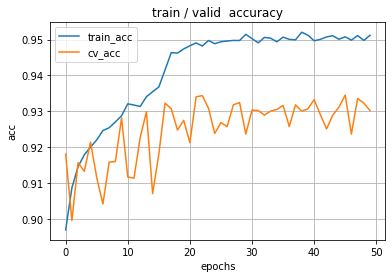

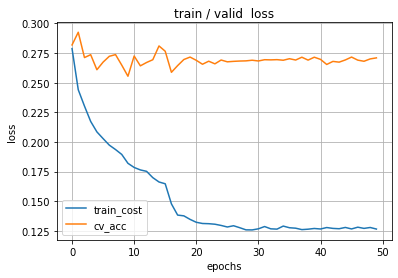

In [ ]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [ ]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 53686
TP: 12173
FP: 1900
TN: 38891
FN: 722

acc: 0.9511604515143612
recall: 0.944009305932532
specificity: 0.9534210977911795
precision: 0.8649896965821076
f1: 0.9027736576683476
mcc: 0.8717288460876872
--------------------

[Dev]Total sample: 6280
TP: 267
FP: 314
TN: 5575
FN: 124

acc: 0.9302547770700637
recall: 0.6828644501278772
specificity: 0.9466802513160129
precision: 0.459552495697074
f1: 0.5493827160493827
mcc: 0.5249867399925209


# Saving model

In [ ]:
# torch.save(model_c0, './C2_TrainDev/model/nn-crop-imbalance/model_c0.pt')
# torch.save(model_c1, './C2_TrainDev/model/nn-crop-imbalance/model_c1.pt')
# torch.save(model_c2, './C2_TrainDev/model/nn-crop-imbalance/model_c2.pt')
# torch.save(model_c3, './C2_TrainDev/model/nn-crop-imbalance/model_c3.pt')
# torch.save(model_c4, './C2_TrainDev/model/nn-crop-imbalance/model_c4.pt')